# Variational Autoencoder for High-Dimensional Data

In this notebook I train a VAE on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) dataset. I use the full dataset but with images rescaled to 16x16 (down from 32x32). The network is a VAE using a ResNet-like architecture for the encoder and decoder as well as linear layers learning the mean and variance of the pixel intensity for each color channel and for each pixel in the image. The prior has been chosen to be a standard normal Gaussian and the approximate posterior is a diagonal covariance Gaussian. Total network depth is 38 layers. The network can be trained in approximately 1 hour on a V100 GPU.

Results are shown in the bottom of this notebook.

### Dependencies

In [0]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image
import PIL.Image as Image

     |████████████████████████████████| 5.6MB 2.8MB/s 
ERROR: torchvision 0.4.1+cu100 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
ERROR: scikit-image 0.15.0 has requirement pillow>=4.3.0, but you'll have pillow 4.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: Pillow 4.3.0
    Uninstalling Pillow-4.3.0:
      Successfully uninstalled Pillow-4.3.0


ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


### Display dataset

Train: (65931, 32, 32, 3)
Val:   (7326, 32, 32, 3)
Test:  (26032, 32, 32, 3)
Transformed data size: torch.Size([64, 3, 16, 16])


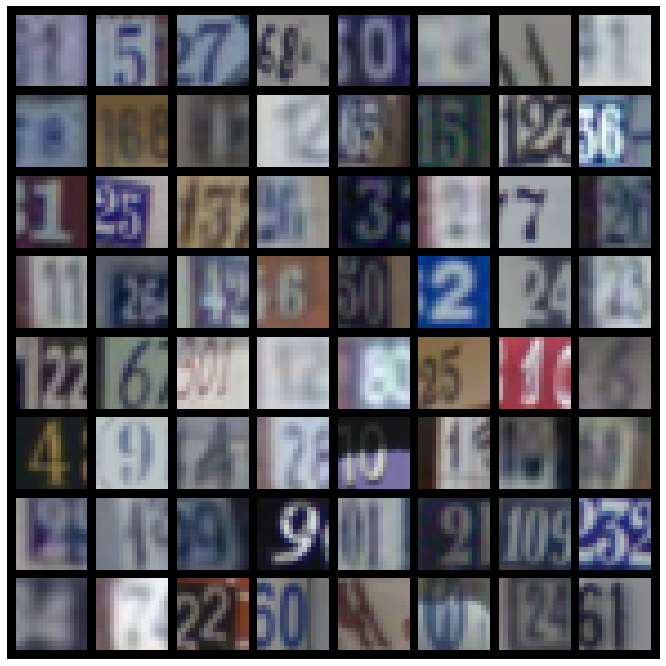

In [0]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
%matplotlib inline
sns.set(style='darkgrid')

data = pkl.load(open('drive/My Drive/Colab Notebooks/hw3-q2.pkl', 'rb'))
data_train, data_val, data_test = data['train']/255, data['valid']/255, data['test']/255
print(f'Train: {data_train.shape}\nVal:   {data_val.shape}\nTest:  {data_test.shape}')

def show(img, renorm=False, nrow=8):
  img_grid = torchvision.utils.make_grid(img, nrow=nrow).numpy()
  plt.figure(figsize=(12,12))
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')
  plt.show()

transform = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize(size=(16, 16)),
  transforms.ToTensor()
])

class ImgDataset(Dataset):
  def __init__(self, X):
    self.X = torch.Tensor(X).permute(0, 3, 1, 2)

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return transform(self.X[idx]).cuda()

batch_size = 64
dl_train = DataLoader(ImgDataset(data_train), batch_size=batch_size, shuffle=True)
dl_val = DataLoader(ImgDataset(data_val), batch_size=batch_size, shuffle=True)
dl_test = DataLoader(ImgDataset(data_test), batch_size=batch_size, shuffle=True)

output = next(iter(dl_train))
print(f'Transformed data size: {output.size()}')
show(output.cpu())

### Plot function

In [0]:
def evaluate(net, dl_test, losses, schedule):
  net.eval()
  loss, nll, kl = losses

  data_batch = next(iter(dl_test))

  recon, recon_z, _, _, _, _ = net(data_batch)
  recon = recon.detach().cpu()
  recon_z = recon_z.detach().cpu()

  z = torch.randn_like(recon_z).cuda()
  samples, _, _ = net.decoder(z)
  samples = samples.detach().cpu()

  samples2, _, _ = net.decoder(z, do_reparam=False)
  samples2 = samples2.detach().cpu()

  betas = [schedule[i] for i in range(len(loss))]

  plt.figure(figsize=(16, 8))

  plt.subplot(2, 4, 1)
  plt.plot(range(len(nll)), (nll/np.log(2))/2)
  plt.title('NLL (bits/dim)')

  plt.subplot(2, 4, 2)
  plt.plot(range(len(kl)), kl)
  plt.title('KL-divergence')

  plt.subplot(2, 4, 3)
  plt.plot(range(len(loss)), loss)
  plt.title('ELBO')

  plt.subplot(2, 4, 4)
  plt.plot(range(len(betas)), betas)
  plt.title('Weight on KL-term (beta)')

  plt.subplot(2, 4, 5)
  plt.title('Original samples')
  img_grid = torchvision.utils.make_grid(data_batch, nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.subplot(2, 4, 6)
  plt.title('Reconstruction')
  img_grid = torchvision.utils.make_grid(torch.clamp(recon, min=0, max=1), nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.subplot(2, 4, 7)
  plt.title('Latent space')
  img_grid = torchvision.utils.make_grid(torch.clamp(recon_z, min=0, max=1), nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.subplot(2, 4, 8)
  plt.title('Samples (with decoder noise)')
  img_grid = torchvision.utils.make_grid(torch.clamp(samples, min=0, max=1), nrow=8).cpu().numpy()
  plt.imshow(np.transpose(img_grid, (1,2,0)))
  plt.axis('off')

  plt.show()
  print('\n\n')

### Define the VAE

In [0]:
class BetaWarmup():
  def __init__(self, num_epochs=200):
    if num_epochs is None or num_epochs < 1:
      self.schedule = [1]
    else:
      self.schedule = np.linspace(0, 1, num_epochs)

  def __getitem__(self, item):
    try:
      return self.schedule[item]
    except:
      return 1


class GatedShortcutConnection(nn.Module):
  # Not implemented. A regular conv layer is used instead.
  def __init__(self):
    super(GatedShortcutConnection, self).__init__()

    self.layers = nn.Sequential(
        nn.ReLU(),
        nn.Conv2d(num_filters//2, num_filters, kernel_size=3, padding=1)
    )

  def forward(self, x):
    return self.layers(x)


class ResidualBlock(nn.Module):
  def __init__(self):
    super(ResidualBlock, self).__init__()

    self.layers = nn.Sequential(
      nn.ReLU(),
      nn.Conv2d(num_filters, num_filters//4, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.Conv2d(num_filters//4, num_filters//2, kernel_size=3, padding=1),
      GatedShortcutConnection()
    )

  def forward(self, x):
    return self.layers(x) + x


class ResidualStack(nn.Module):
  def __init__(self, num_blocks=5):
    super(ResidualStack, self).__init__()

    self.layers = nn.Sequential(*[ResidualBlock() for _ in range(num_blocks)])

  def forward(self, x):
    return F.relu(self.layers(x))


class ImgCoder(nn.Module):
  def __init__(self, encoder=None, decoder=None):
    super(ImgCoder, self).__init__()
    assert encoder is not None or decoder is not None

    self.num_colors = 3

    if encoder:
      self.layers = nn.Sequential(
        nn.Conv2d(self.num_colors, num_filters//2, kernel_size=4, stride=2, padding=9),
        nn.ReLU(),
        nn.Conv2d(num_filters//2, num_filters, kernel_size=4, stride=2, padding=9),
        nn.ReLU(),
        nn.Conv2d(num_filters, num_filters, kernel_size=3, stride=1, padding=1),
        ResidualStack()
      )
      self.mu = nn.Linear(num_filters*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)
      self.log_var = nn.Linear(num_filters*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)

    elif decoder:
      self.layers = nn.Sequential(
        nn.Conv2d(self.num_colors, num_filters, kernel_size=3, stride=1, padding=1),
        ResidualStack(),
        nn.ConvTranspose2d(num_filters, num_filters//2, kernel_size=4, stride=2, padding=9),
        nn.ReLU(),
        nn.ConvTranspose2d(num_filters//2, self.num_colors, kernel_size=4, stride=2, padding=9)
      )
      self.mu = nn.Linear(self.num_colors*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)
      self.log_var = nn.Linear(self.num_colors*num_pixels*num_pixels, self.num_colors*num_pixels*num_pixels)

  def reparam(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)

    return mu + eps * std

  def forward(self, x, do_reparam=True):
    x = self.layers(x)
    x = x.view(x.size(0), -1)

    mu = self.mu(x).view(x.size(0), self.num_colors, num_pixels, num_pixels)
    log_var = self.log_var(x).view(x.size(0), self.num_colors, num_pixels, num_pixels)

    if do_reparam:
      x = self.reparam(mu, log_var)
    else:
      x = mu

    return x, mu, log_var


class ImgVAE(nn.Module):
  def __init__(self):
    super(ImgVAE, self).__init__()

    self.encoder = ImgCoder(encoder=True)
    self.decoder = ImgCoder(decoder=True)

  def forward(self, x):
    if not isinstance(x, torch.Tensor):
      x = torch.Tensor(x).cuda()

    if not x.shape[1] == 3:
      x = x.permute(0, 3, 1, 2)

    z, z_mu, z_log_var = self.encoder(x)
    x, x_mu, x_log_var = self.decoder(z)

    return x, z, z_mu, z_log_var, x_mu, x_log_var

  def kl(self, z, mu, log_var):
    qz = log_pdf(z, mu, log_var)
    pz = log_standard_pdf(z)

    return qz - pz

  def elbo(self, x, outputs, beta):
    x_hat, z, z_mu, z_log_var, x_mu, x_log_var = outputs

    nll = -torch.mean(log_pdf(x, x_mu, x_log_var))
    kl = torch.mean(self.kl(z, z_mu, z_log_var))

    return nll + beta * kl, nll, kl


def log_standard_pdf(x):
  return torch.sum(-0.5 * np.log(2 * np.pi) - x**2 / 2, dim=(-3))

  
def log_pdf(x, mu, log_var):
  logs = -0.5 * np.log(2 * np.pi) - log_var / 2 - (x - mu)**2 / (2 * torch.exp(log_var))
  return torch.sum(logs, dim=(-3))


num_filters = 256
num_pixels = 16

print('Initializing network...')
net = ImgVAE()

print('Moving network to GPU...')
net = net.cuda()

print('Running a forward pass...')
outputs = net(next(iter(dl_train)))

print('Done!')

Initializing network...
Moving network to GPU...
Running a forward pass...
Done!


### Fit the VAE

Epoch 1/50, ELBO: -1.817165007328779, KL: 816050.323858089


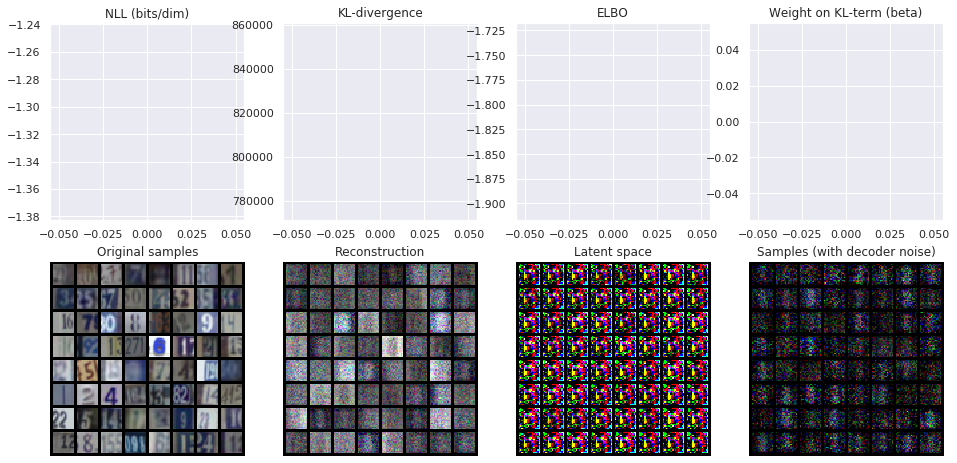




Epoch 2/50, ELBO: 3.5011542387808934, KL: 140.39038331068465
Epoch 3/50, ELBO: -3.6799037315450054, KL: 1.1100834201078296
Epoch 4/50, ELBO: -4.208892446947144, KL: 1.0495481211276567
Epoch 5/50, ELBO: -4.539941666544814, KL: 0.9070960034107722
Epoch 6/50, ELBO: -4.8022834930919425, KL: 0.7458595380866331


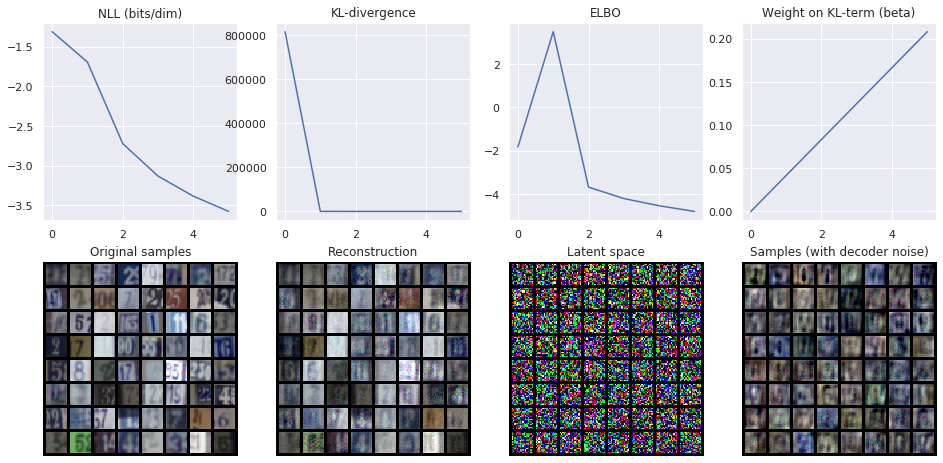




Epoch 7/50, ELBO: -5.044753762845502, KL: 0.6828315386369781
Epoch 8/50, ELBO: -5.152521911809794, KL: 0.6615702219661524
Epoch 9/50, ELBO: -5.2382163118090475, KL: 0.6434078938630342
Epoch 10/50, ELBO: -5.284157550878367, KL: 0.6217382582036415
Epoch 11/50, ELBO: -5.294098145977949, KL: 0.5998386377622269


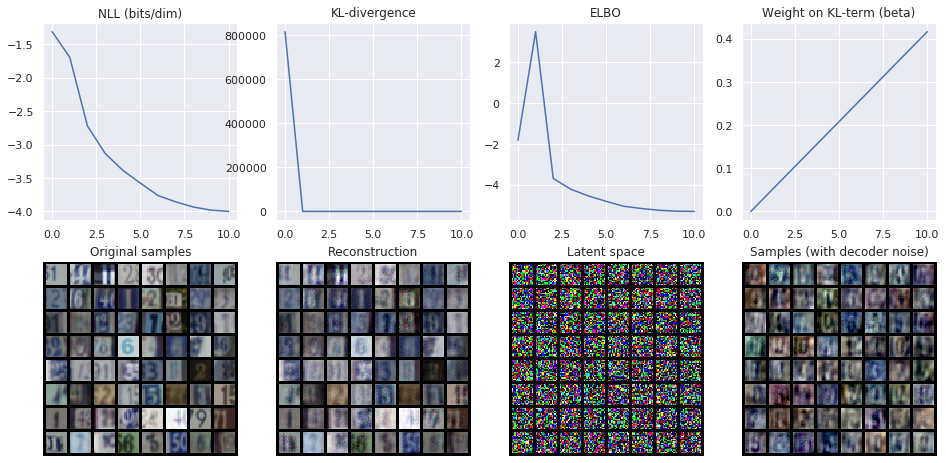




Epoch 12/50, ELBO: -5.327517138998215, KL: 0.5784585482281002
Epoch 13/50, ELBO: -5.272296907830077, KL: 0.5588821296721957
Epoch 14/50, ELBO: -5.334745785429221, KL: 0.5415553704670167
Epoch 15/50, ELBO: -5.34215325088205, KL: 0.5314263081689348
Epoch 16/50, ELBO: -5.344061251176895, KL: 0.5199073329640175


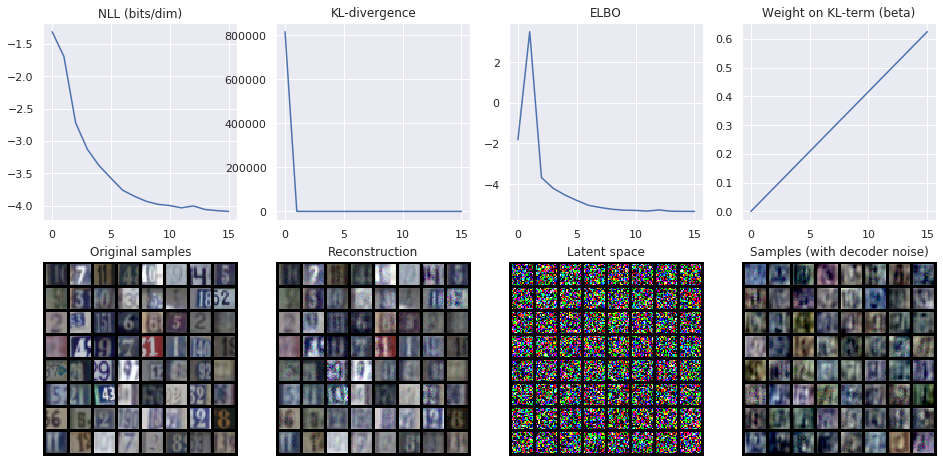




Epoch 17/50, ELBO: -5.360451937415552, KL: 0.5118242439196945
Epoch 18/50, ELBO: -5.353391586288911, KL: 0.5034140579684282
Epoch 19/50, ELBO: -5.346188813014359, KL: 0.4950216761442438
Epoch 20/50, ELBO: -5.331509615586407, KL: 0.48690389598259987
Epoch 21/50, ELBO: -5.332655766077347, KL: 0.4795386693526193


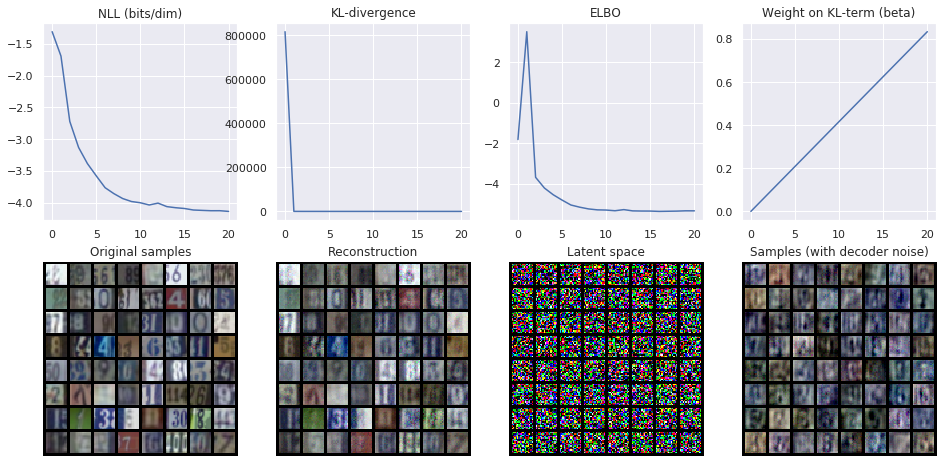




Epoch 22/50, ELBO: -5.329603865814949, KL: 0.47244318125897766
Epoch 23/50, ELBO: -5.303145032618141, KL: 0.4641764414009831
Epoch 24/50, ELBO: -5.3016157261268475, KL: 0.45651706720762875
Epoch 25/50, ELBO: -5.300997075470296, KL: 0.44800887419458274
Epoch 26/50, ELBO: -5.305160669535832, KL: 0.44126797609833346


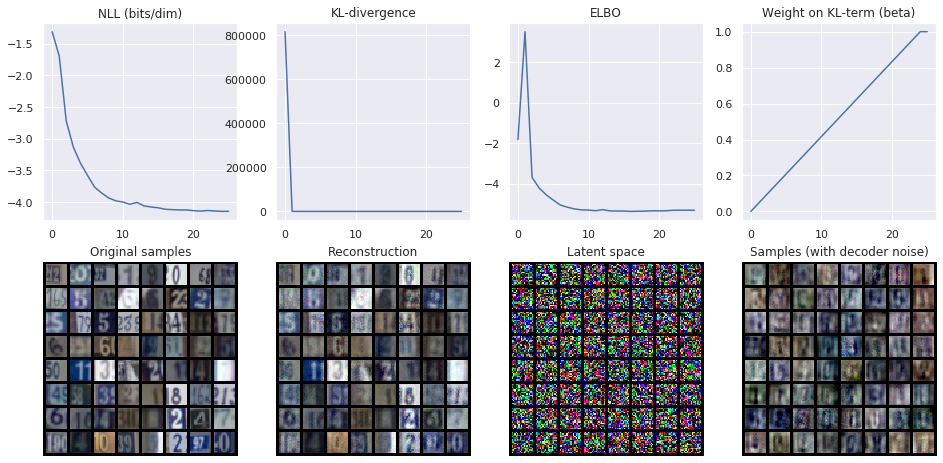




Epoch 27/50, ELBO: -5.333782715894549, KL: 0.4337504009791188
Epoch 28/50, ELBO: -5.367843143230035, KL: 0.4179875599482358
Epoch 29/50, ELBO: -5.390972238738599, KL: 0.4060298247781341
Epoch 30/50, ELBO: -5.396537611024341, KL: 0.40276194610258076
Epoch 31/50, ELBO: -5.415865120207882, KL: 0.40159764883011784


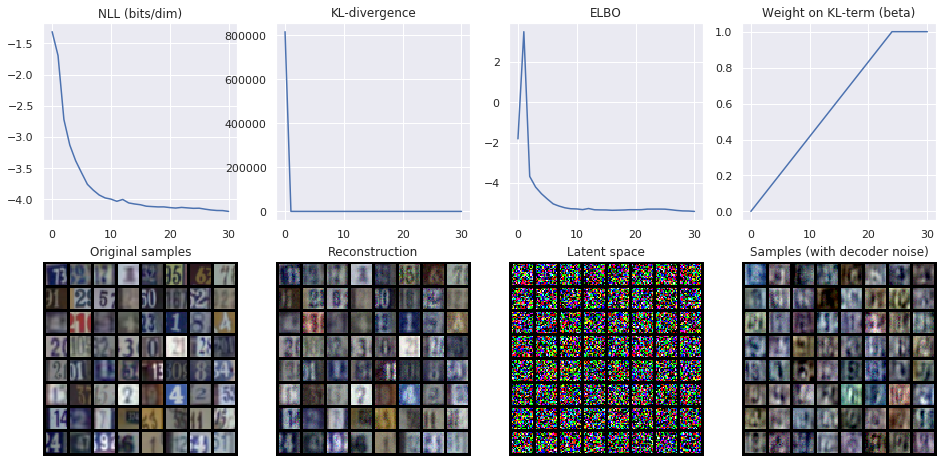




Epoch 32/50, ELBO: -5.424939167603605, KL: 0.4003897797240434
Epoch 33/50, ELBO: -5.43672850199051, KL: 0.4004523586174681
Epoch 34/50, ELBO: -5.430204410441979, KL: 0.39904876303372167
Epoch 35/50, ELBO: -5.451540618123185, KL: 0.39998576212692444
Epoch 36/50, ELBO: -5.4448244971748005, KL: 0.3991885902405248


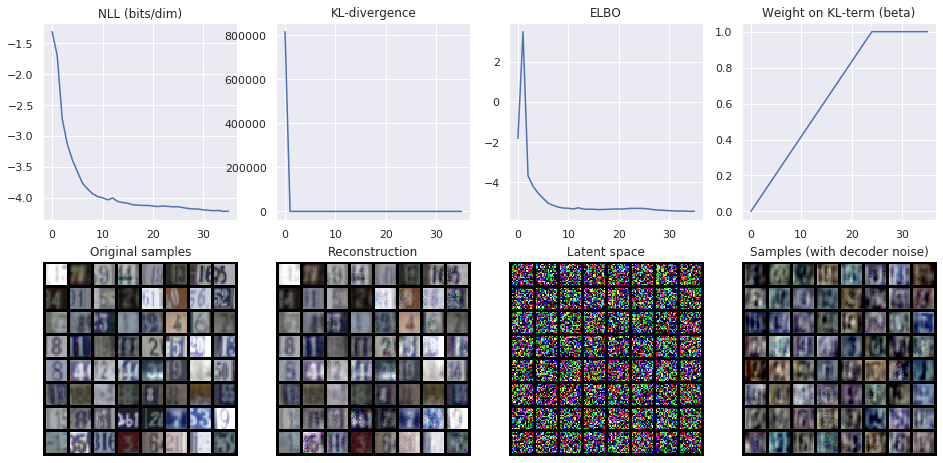




Epoch 37/50, ELBO: -5.458271123273759, KL: 0.39954343267601744
Epoch 38/50, ELBO: -5.463943727957636, KL: 0.39927695935843177
Epoch 39/50, ELBO: -5.45569832641794, KL: 0.39852496316777514
Epoch 40/50, ELBO: -5.474646629348296, KL: 0.3991235548668296
Epoch 41/50, ELBO: -5.477384121873562, KL: 0.3990802731939477


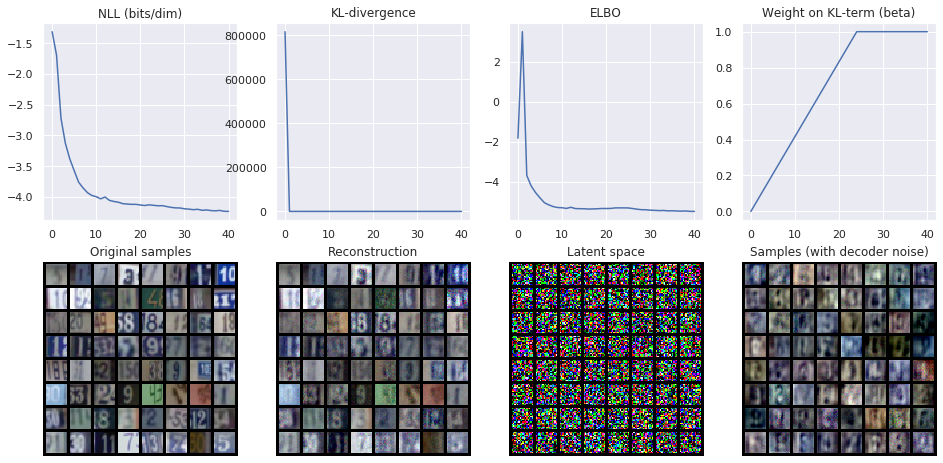




Epoch 42/50, ELBO: -5.486047429326202, KL: 0.3990436983732895
Epoch 43/50, ELBO: -5.483643974411499, KL: 0.3985341279166746
Epoch 44/50, ELBO: -5.495993391734437, KL: 0.3990448665896396
Epoch 45/50, ELBO: -5.489257712137572, KL: 0.39861282827666844
Epoch 46/50, ELBO: -5.4983933640266365, KL: 0.3987136632059525


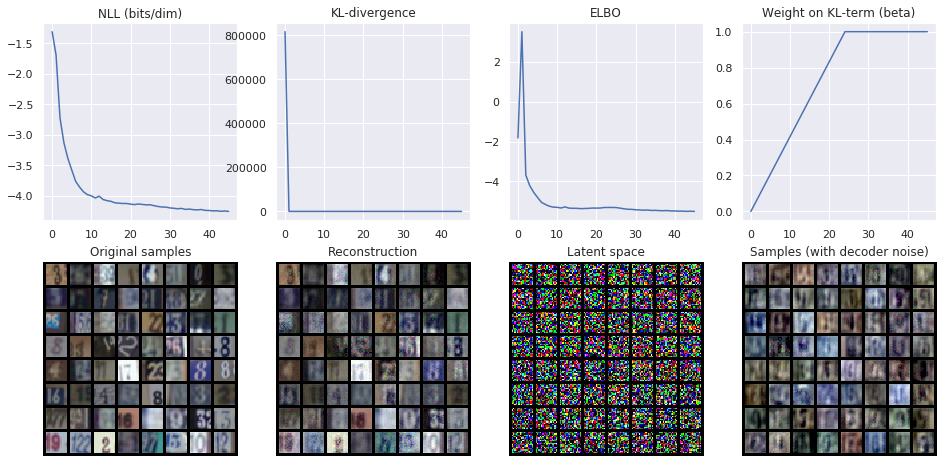




Epoch 47/50, ELBO: -5.504631392592718, KL: 0.39868901813064933
Epoch 48/50, ELBO: -5.503511281295614, KL: 0.39838317958737435
Epoch 49/50, ELBO: -5.5068385668106155, KL: 0.39833526418812637
Epoch 50/50, ELBO: -5.514393410095304, KL: 0.39850186049996017


In [0]:
def fit(dl_train, num_epochs=50):
  net = ImgVAE().cuda()
  optimizer = optim.Adam(net.parameters())
  schedule = BetaWarmup(num_epochs//2)

  train_elbo, valid_elbo = [], []
  train_nll, valid_nll = [], []
  train_kl, valid_kl = [], []

  for epoch in range(num_epochs):

    net.train()
    batch_elbo, batch_nll, batch_kl = [], [], []

    for x in dl_train:

      outputs = net(x)
      elbo, nll, kl = net.elbo(x, outputs, schedule[epoch])

      optimizer.zero_grad()
      elbo.backward()
      optimizer.step()
      
      batch_elbo.append(elbo.item())
      batch_nll.append(nll.item())
      batch_kl.append(kl.item())

    train_elbo.append(np.mean(batch_elbo))
    train_nll.append(np.mean(batch_nll))
    train_kl.append(np.mean(batch_kl))

    print(f'Epoch {epoch+1}/{num_epochs}, ELBO: {train_elbo[-1]}, KL: {train_kl[-1]}')

    if epoch % 5 == 0:
      evaluate(net, dl_val, (np.array(train_elbo), np.array(train_nll), np.array(train_kl)), schedule)

  return net, (np.array(train_elbo), np.array(train_nll), np.array(train_kl)), schedule


net, losses, schedule = fit(dl_train, num_epochs=50)